# 0.) Load Libraries and Setup Datapaths

In [1]:
# Load libraries
%matplotlib inline
import cv2
import IPython.display as disp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rand
import re
import seaborn as sns
import sys
import tensorflow as tf

from itertools import product
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir
from os.path import isdir, isfile, join as osjoin
from random import shuffle

# Setup datapaths
base_path = './datasets/IntelImageClassification/'

pred_path = 'seg_pred/seg_pred/'
test_path = 'seg_test/seg_test/'
train_path = 'seg_train/seg_train/'

# Func. to make full paths from base_path
def route(*args):
    full_path = base_path
    for a in args:
        full_path = osjoin(full_path, a)
        
    return full_path

# Make sure paths exist
if isdir(base_path):
    msg = "Couldn't find the dataset path {}. Please check that it is correct."
    
    if not isdir(route(pred_path)):
        print(msg.format(route(pred_path)))
    if not isdir(route(test_path)):
        print(msg.format(route(train_path)))
    if not isdir(route(train_path)):
        print(msg.format(route(train_path)))
else:
    print(f"The dataset path {base_path} doesn't seem to exist. Please make sure the path to the data is correct.")

In [2]:
# Check for CUDA
CUDA = tf.test.gpu_device_name()

print("CUDA enabled" if CUDA != '' else "CUDA not available")

CUDA enabled


# 1.) Load Images

In [3]:
# Generate labels
labels = []
for folder in listdir(route(train_path)):
    assert(isdir(route(test_path, folder))) # Sanity check
    labels.append(folder)
    
# Func. to eliminate code reuse in loading images
# (adapted from Assignment document)
def load_img(path, x, y):
    for f in sorted([_ for _ in listdir(path) if _.lower().endswith('.jpg')]):
        x += [cv2.resize(cv2.imread(osjoin(path,f)), IMGSIZE)]
        y += [labels.index(label)]
        
    return x, y

In [4]:
%%time
# Load images

IMGSIZE = (128, 128)
x_tr, y_tr, x_ts, y_ts = [], [], [], []
for label in labels:
    # Load training set
    tr_path = route(train_path, label)
    x_tr, y_tr = load_img(tr_path, x_tr, y_tr)
      
    # Load testing set
    ts_path = route(test_path, label)
    x_ts, y_ts = load_img(ts_path, x_ts, y_ts)

Wall time: 50.5 s


In [5]:
# Check the number of channels
channels = len(x_tr[0][0][0])

# Since these are coloured images we expect 3
disp.display_markdown(f"__Number of Channels:__ {channels}", raw=True)

assert(channels == 3)

__Number of Channels:__ 3

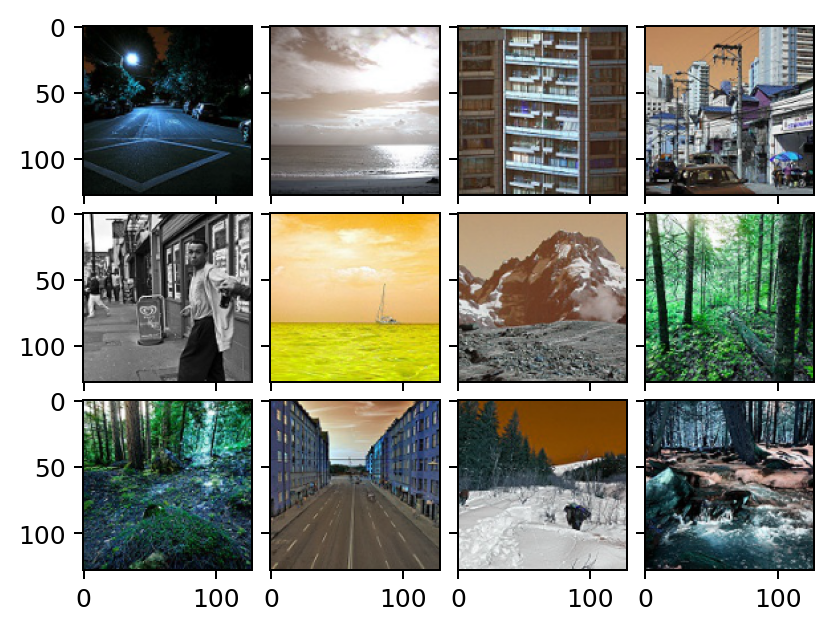

In [6]:
# Display some random images from the set
nrow, ncol = 3, 4
num = nrow * ncol

sample_images = rand.sample(x_tr, num)

fig = plt.figure(dpi=180)
grid = ImageGrid(fig, 111, nrows_ncols=(nrow, ncol), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im)

plt.show()

# 2.) Convert Imageset to Numpy Array and Scale

In [7]:
# Convert
x_tr = np.array(x_tr, dtype=np.float)
y_tr = np.array(y_tr)

x_ts = np.array(x_ts, dtype=np.float)
y_ts = np.array(y_ts)

# Scale
x_tr /= 255.0
x_ts /= 255.0

# Check sanity on shapes
disp.display_markdown(f"__Training Set Shape:__ {x_tr.shape}", raw=True)
disp.display_markdown(f"__Testing Set Shape:__ {x_ts.shape}", raw=True)

disp.display_markdown(f"__Training Targets Shape:__ {y_tr.shape}", raw=True)
disp.display_markdown(f"__Testing Targets Shape:__ {y_ts.shape}", raw=True)

# Check sanity on scale
disp.display_markdown(f"__Training Set Min/Max:__ {x_tr.min()}/{x_tr.max()}", raw=True)
disp.display_markdown(f"__Training Set Min/Max:__ {x_ts.min()}/{x_ts.max()}", raw=True)

__Training Set Shape:__ (14034, 128, 128, 3)

__Testing Set Shape:__ (3000, 128, 128, 3)

__Training Targets Shape:__ (14034,)

__Testing Targets Shape:__ (3000,)

__Training Set Min/Max:__ 0.0/1.0

__Training Set Min/Max:__ 0.0/1.0

# 3.) Create a CNN

In [8]:
EPOCHS = 10

In [9]:
# CNN construction
cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), name='conv_1', activation='relu',
                               data_format='channels_last'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), name='conv_2', activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnn.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [10]:
# Build/Compile CNN
tf.random.set_seed(42)

def build_comp(model):
    tf.keras.backend.clear_session()
    model.build(input_shape=(None, 128, 128, 3))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    
    return model

cnn = build_comp(cnn)

### Train

In [11]:
%%time
history = cnn.fit(x_tr, y_tr, epochs=EPOCHS, shuffle=True)

Epoch 1/10
439/439 [==============================] - 5s 11ms/step - loss: 0.9993 - accuracy: 0.6223
Epoch 2/10
439/439 [==============================] - 5s 12ms/step - loss: 0.6355 - accuracy: 0.7676
Epoch 3/10
439/439 [==============================] - 6s 13ms/step - loss: 0.4105 - accuracy: 0.8522
Epoch 4/10
439/439 [==============================] - 6s 13ms/step - loss: 0.2123 - accuracy: 0.9290
Epoch 5/10
439/439 [==============================] - 6s 13ms/step - loss: 0.1106 - accuracy: 0.9652
Epoch 6/10
439/439 [==============================] - 5s 12ms/step - loss: 0.0841 - accuracy: 0.9750
Epoch 7/10
439/439 [==============================] - 5s 12ms/step - loss: 0.0658 - accuracy: 0.9801
Epoch 8/10
439/439 [==============================] - 5s 11ms/step - loss: 0.0554 - accuracy: 0.9844
Epoch 9/10
439/439 [==============================] - 5s 11ms/step - loss: 0.0407 - accuracy: 0.9888
Epoch 10/10
439/439 [==============================] - 5s 12ms/step - loss: 0.0544 - accura

### Test

In [12]:
def test(model):
    y_pred = np.argmax(model.predict(x_ts), axis=-1)
    print(f'Accuracy = {sum(y_pred==y_ts)/y_ts.shape[0]:.3f}')

test(cnn)

Accuracy = 0.754


# 4.) Add Dropout/Regularization

Here I ran three models with the final one performing best.
* L1 Regularized: 73% Acc.
* Dropout: 77% Acc.
* L2 Regularization + Dropout + Extra Layers: 84% Accuracy (Can't recreate run -_-)

The final model is only slightly more accurate (~2-3%) with L2 and Dropout as just the same architecture (4 conv. layers) w/o the regularization. 

### L1 Regularization

In [13]:
# Define Regularizer
regularizer = tf.keras.regularizers.l1(l=0.01)


# Define CNN
cnnl1 = tf.keras.Sequential()

# CNN Layer 1
cnnl1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), name='conv_1', activation='relu',
                                 data_format='channels_last', kernel_regularizer=regularizer))
cnnl1.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))

# CNN Layer 2
cnnl1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), name='conv_2', activation='relu',
                                 kernel_regularizer=regularizer))
cnnl1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

cnnl1.add(tf.keras.layers.Flatten())
cnnl1.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnnl1.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [14]:
%%time
# Build/Compile CNN
cnnl1 = build_comp(cnnl1)

# Train
history = cnnl1.fit(x_tr, y_tr, epochs=EPOCHS, shuffle=True)

Epoch 1/10
439/439 [==============================] - 5s 12ms/step - loss: 2.5349 - accuracy: 0.5731
Epoch 2/10
439/439 [==============================] - 5s 12ms/step - loss: 1.3768 - accuracy: 0.6744
Epoch 3/10
439/439 [==============================] - 5s 11ms/step - loss: 1.1264 - accuracy: 0.7078
Epoch 4/10
439/439 [==============================] - 5s 11ms/step - loss: 1.0148 - accuracy: 0.7369
Epoch 5/10
439/439 [==============================] - 5s 11ms/step - loss: 0.9287 - accuracy: 0.7619
Epoch 6/10
439/439 [==============================] - 5s 11ms/step - loss: 0.8493 - accuracy: 0.7874
Epoch 7/10
439/439 [==============================] - 5s 11ms/step - loss: 0.7731 - accuracy: 0.8091
Epoch 8/10
439/439 [==============================] - 5s 11ms/step - loss: 0.6924 - accuracy: 0.8396
Epoch 9/10
439/439 [==============================] - 5s 11ms/step - loss: 0.6090 - accuracy: 0.8707
Epoch 10/10
439/439 [==============================] - 5s 11ms/step - loss: 0.5505 - accura

In [15]:
# Test
test(cnnl1)

Accuracy = 0.736


### Dropout

In [16]:
# Define CNN
cnndo = tf.keras.Sequential()

# CNN Layer 1
cnndo.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), name='conv_1', activation='relu',
                                 data_format='channels_last'))
cnndo.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))

# CNN Layer 2
cnndo.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), name='conv_2', activation='relu'))
cnndo.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))
cnndo.add(tf.keras.layers.Dropout(0.2))

cnndo.add(tf.keras.layers.Flatten())
cnndo.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnndo.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [17]:
%%time
# Build/Compile CNN
cnndo = build_comp(cnndo)

# Train
history = cnndo.fit(x_tr, y_tr, epochs=EPOCHS, shuffle=True)

Epoch 1/10
439/439 [==============================] - 5s 12ms/step - loss: 1.0952 - accuracy: 0.6029
Epoch 2/10
439/439 [==============================] - 5s 12ms/step - loss: 0.6717 - accuracy: 0.7514
Epoch 3/10
439/439 [==============================] - 5s 12ms/step - loss: 0.4913 - accuracy: 0.8209
Epoch 4/10
439/439 [==============================] - 5s 12ms/step - loss: 0.3237 - accuracy: 0.8842
Epoch 5/10
439/439 [==============================] - 6s 13ms/step - loss: 0.2088 - accuracy: 0.9296
Epoch 6/10
439/439 [==============================] - 5s 12ms/step - loss: 0.1214 - accuracy: 0.9598
Epoch 7/10
439/439 [==============================] - 6s 13ms/step - loss: 0.1017 - accuracy: 0.9668
Epoch 8/10
439/439 [==============================] - 5s 11ms/step - loss: 0.0713 - accuracy: 0.9795
Epoch 9/10
439/439 [==============================] - 5s 12ms/step - loss: 0.0604 - accuracy: 0.9815
Epoch 10/10
439/439 [==============================] - 5s 12ms/step - loss: 0.0430 - accura

In [18]:
# Test
test(cnndo)

Accuracy = 0.769


### L2 Regularization + Dropout

In [31]:
# Define Regularizers
reg1 = tf.keras.regularizers.l2(l=0.001)
reg2 = tf.keras.regularizers.l2(l=0.01)

# Define CNN
cnnl2 = tf.keras.Sequential()

# CNN Layer 1
cnnl2.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), name='conv_1', activation='relu',
                                 data_format='channels_last', kernel_regularizer=reg1))
cnnl2.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))

# CNN Layer 2
cnnl2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), name='conv_2', activation='relu',
                                 kernel_regularizer=reg1))
cnnl2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

# CNN Layer 3
cnnl2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), name='conv_3', activation='relu',
                                 kernel_regularizer=reg2))
cnnl2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_3'))

# CNN Layer 4
cnnl2.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(4,4), name='conv_4', activation='relu',
                                 kernel_regularizer=reg2))
cnnl2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_4'))
cnnl2.add(tf.keras.layers.Dropout(0.2))

# Flatten and Fully Connect
cnnl2.add(tf.keras.layers.Flatten())
cnnl2.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnnl2.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [32]:
%%time
# Build/Compile CNN
cnnl2 = build_comp(cnnl2)

# Train
history = cnnl2.fit(x_tr, y_tr, epochs=EPOCHS, shuffle=True)

Epoch 1/10
439/439 [==============================] - 4s 9ms/step - loss: 1.2966 - accuracy: 0.5532
Epoch 2/10
439/439 [==============================] - 4s 9ms/step - loss: 0.9112 - accuracy: 0.6833
Epoch 3/10
439/439 [==============================] - 4s 9ms/step - loss: 0.7958 - accuracy: 0.7277
Epoch 4/10
439/439 [==============================] - 4s 9ms/step - loss: 0.7392 - accuracy: 0.7610
Epoch 5/10
439/439 [==============================] - 4s 9ms/step - loss: 0.7044 - accuracy: 0.7688
Epoch 6/10
439/439 [==============================] - 4s 9ms/step - loss: 0.6680 - accuracy: 0.7911
Epoch 7/10
439/439 [==============================] - 4s 9ms/step - loss: 0.6497 - accuracy: 0.7942
Epoch 8/10
439/439 [==============================] - 4s 9ms/step - loss: 0.6004 - accuracy: 0.8134
Epoch 9/10
439/439 [==============================] - 4s 10ms/step - loss: 0.5897 - accuracy: 0.8160
Epoch 10/10
439/439 [==============================] - 5s 11ms/step - loss: 0.5760 - accuracy: 0.82

In [33]:
# Test
test(cnnl2)

Accuracy = 0.812
